## Import Library dan Dataset

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
# mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.listdir('/content/drive/MyDrive/Data Portofolio/X-RAY/Dataset')

['1', '2', '3', '0']

In [6]:
# kita akan menggunakan image generator untuk menghasilkan gambar dalam bentuk tensor
# 20 persen data untuk cross validation
image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [7]:
# menghasilkan batch berisi 40 gambar
# jumlah total gambar adalah 133 dikali 4 kelas sama dengan 532
train_generator = image_generator.flow_from_directory(batch_size=40, directory='/content/drive/MyDrive/Data Portofolio/X-RAY', subset='training', target_size=(256, 256), class_mode='categorical',shuffle=True)

Found 458 images belonging to 2 classes.


In [8]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= '/content/drive/MyDrive/Data Portofolio/X-RAY', shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")

Found 114 images belonging to 2 classes.


In [9]:
# generate batch
train_images , train_labels = next(train_generator)

In [10]:
train_images.shape

(40, 256, 256, 3)

In [11]:
train_labels.shape

(40, 2)

In [12]:
# kita harus melabeli
nama_label = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

## Visualisasi Dataset

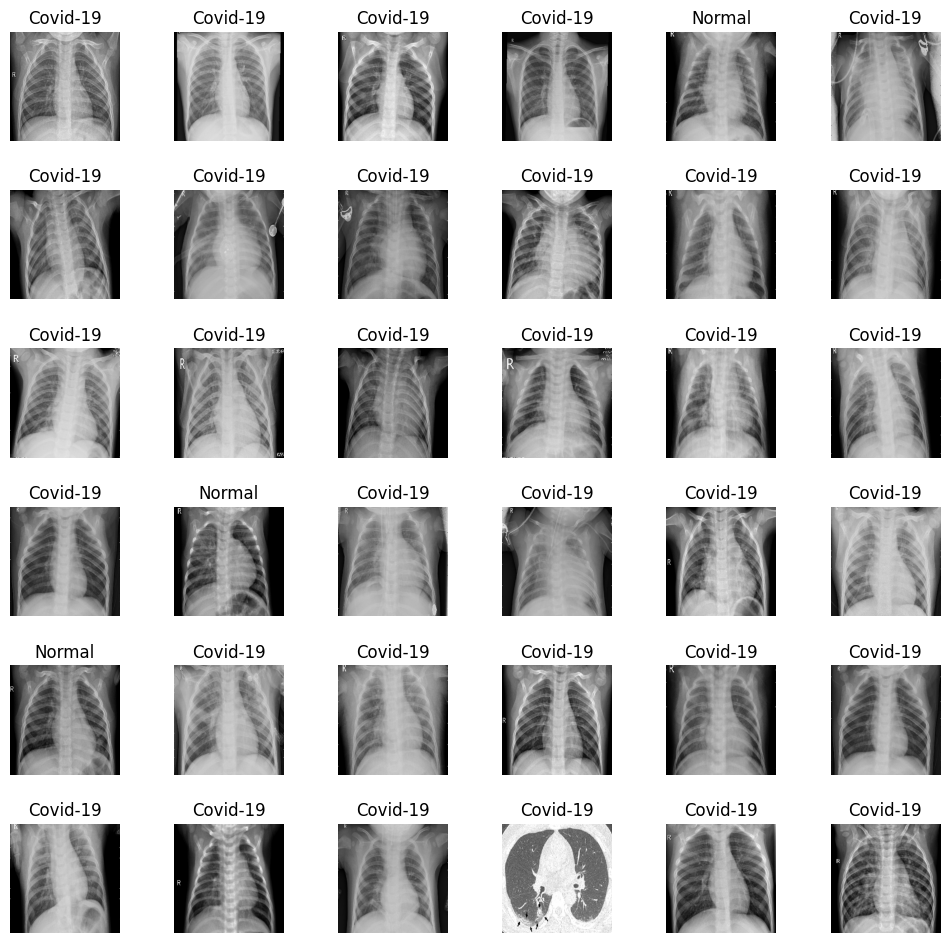

In [13]:
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(nama_label[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

## Import Model dengan pretrained weights

In [14]:
basemodel = ResNet50(weights='imagenet',include_top=False,input_tensor=Input(shape=(256,256,3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [15]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [16]:
# bekukan layer basemodel sampai stage 4 dan hanya latih ulang stage 5
for layer in basemodel.layers[:-10] :
  layer.trainable = False

In [17]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(512, activation = "relu")(headmodel)
headmodel = Dropout(0.4)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(learning_rate=1e-4),metrics=['accuracy'])

In [18]:
# gunakan earlystopping untuk menghentikan training lebih awal jika model sudah tidak membaik
earlystopping = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=20)

# model checkpoint untuk menyimpan weights model selama training , memastikan tidak kehilangan model terbaik
checkpointer = ModelCheckpoint(filepath='weights.keras',verbose=1,save_best_only=True)

In [19]:
# buat train generator
train_generator = image_generator.flow_from_directory(
    # tiap step memproses 4 gambar sekaligus
    batch_size = 4,
    directory = '/content/drive/MyDrive/Data Portofolio/X-RAY/Dataset',
    shuffle = True,
    target_size = (256,256),
    # untuk multiclass classification
    class_mode = 'categorical',
    subset = "training"
)

Found 428 images belonging to 4 classes.


In [20]:
# buat val generator
val_generator = image_generator.flow_from_directory(
    batch_size = 4,
    directory = '/content/drive/MyDrive/Data Portofolio/X-RAY/Dataset',
    shuffle = True,
    target_size = (256,256),
    class_mode = 'categorical',
    subset = "validation"
)


Found 104 images belonging to 4 classes.


In [21]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 50, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2705 - loss: 1.7401
Epoch 1: val_loss improved from inf to 1.49611, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - accuracy: 0.2711 - loss: 1.7382 - val_accuracy: 0.2500 - val_loss: 1.4961
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4386 - loss: 1.2670
Epoch 2: val_loss did not improve from 1.49611
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.4390 - loss: 1.2664 - val_accuracy: 0.2500 - val_loss: 2.4299
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5191 - loss: 1.1411
Epoch 3: val_loss improved from 1.49611 to 0.93327, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.5192 - loss: 1.1403 - val_accuracy: 0.6442 - val_loss: 0.9333
Epoch 4/50
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6430 - loss: 0.8387
Epoch 4: val_loss improved from 0.93327 to 0.86955, saving model to weights.keras
107/107 ━

In [22]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

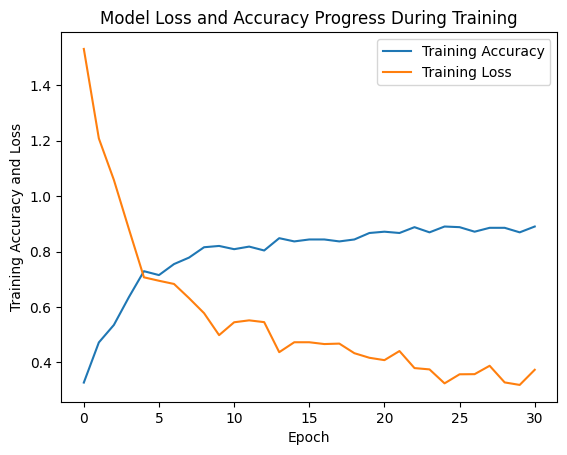

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

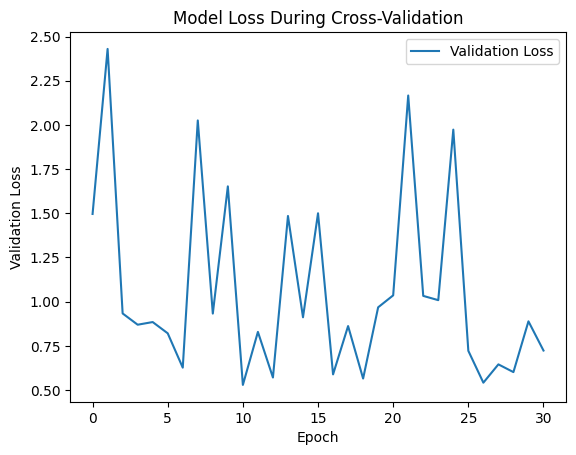

In [24]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

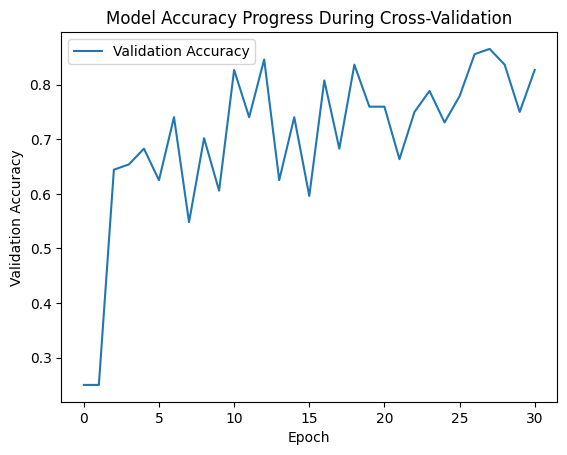

In [25]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [26]:
link_folder_tes = '/content/drive/MyDrive/Data Portofolio/X-RAY/Test'

In [27]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(
    batch_size = 40,
    directory = link_folder_tes,
    shuffle = True,
    target_size = (256,256),
    class_mode = 'categorical'
)
evaluate = model.evaluate(test_generator,steps=test_generator.n//4,verbose=1)
print('akurasi test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.6750 - loss: 1.2948 
akurasi test : 0.675000011920929


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [28]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(link_folder_tes))):
  for item in os.listdir(os.path.join(link_folder_tes,str(i))):
    img= cv2.imread(os.path.join(link_folder_tes,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━

In [29]:
len(original)

40

In [30]:
score = accuracy_score(original,prediction)
print('test accuracy : {}'.format(score))

test accuracy : 0.675


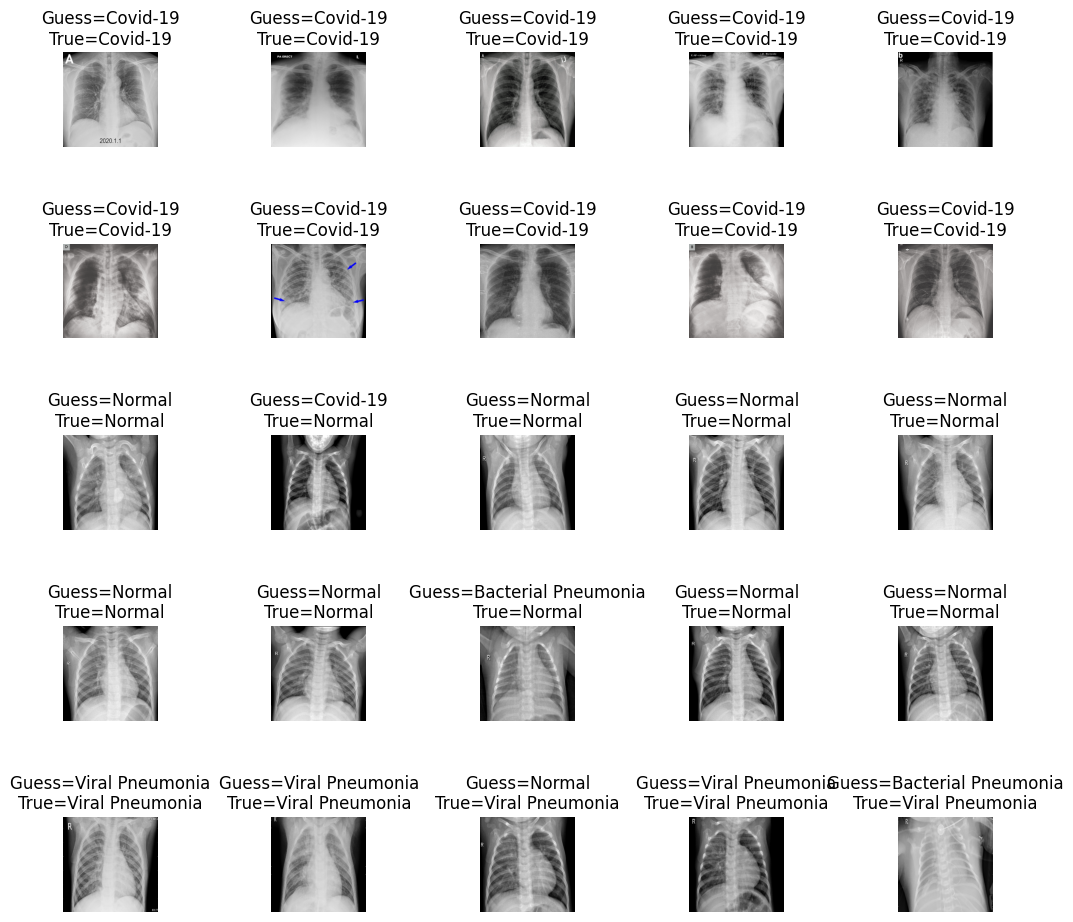

In [31]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(nama_label[prediction[i]]), str(nama_label[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2)

In [32]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.67      0.80      0.73        10
           2       0.67      0.60      0.63        10
           3       0.60      0.30      0.40        10

    accuracy                           0.68        40
   macro avg       0.66      0.67      0.65        40
weighted avg       0.66      0.68      0.65        40



Text(0.5, 1.0, 'Confusion_matrix')

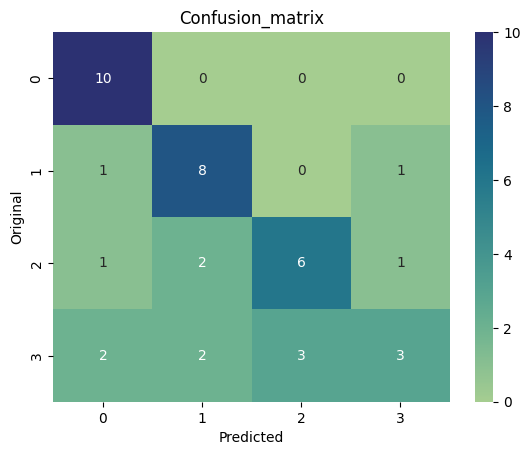

In [33]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax,cmap='crest')

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')